In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
FOLDER = 'E:/diss/reuters/'

In [9]:
df = pd.read_csv(FOLDER + "reuters_cuts.csv")
df_val = df[df['seqpart'] == 1]
df_test = df[df['seqpart'] == 2]

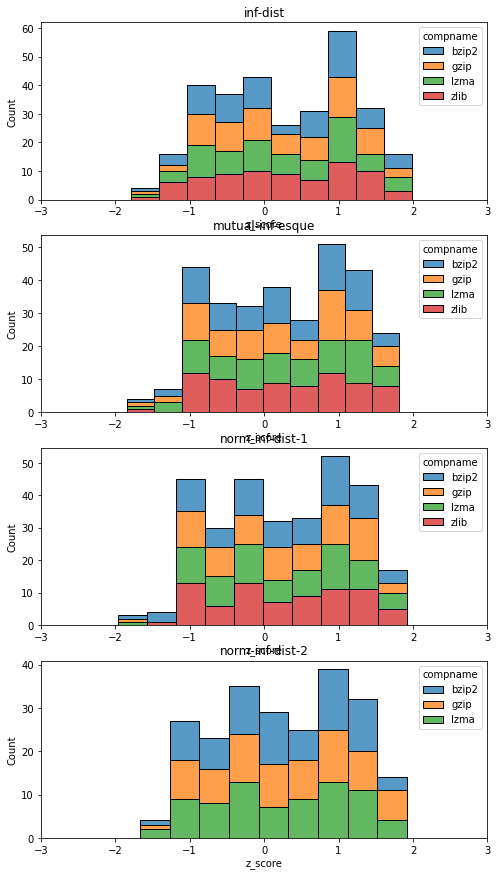

In [18]:
ncd_formulae = list(df['ncd_formula'].unique())
fig, axs = plt.subplots(len(ncd_formulae), 1, figsize=(8, 15))

for i, ncd_formula in enumerate(ncd_formulae):
    axs[i].set_title(ncd_formula)
    axs[i].set_xlim((-3.0, 3.0))
    sns.histplot(df_val[df_val['ncd_formula'] == ncd_formula],
                 x="z_score", hue="compname", multiple="stack", ax=axs[i])

plt.show()